## Antenna

Example product: https://docs.rs-online.com/d481/0900766b81673199.pdf or https://www.wifi-shop24.com/cyberbajt-yagi-directional-wifi-antenna-16dbi
 
- Gain 14dBi
- F/B ratio 28dB
- horizontal beam width 36 degrees
- vertical beam width 35 degrees
 (I assume these are FWHM)
 
 Or this datasheet I can extract the pattern from:
 https://www.rfsolutions.co.uk/downloads/627511f0d698a242ANT-24G-YAG16-2.pdf

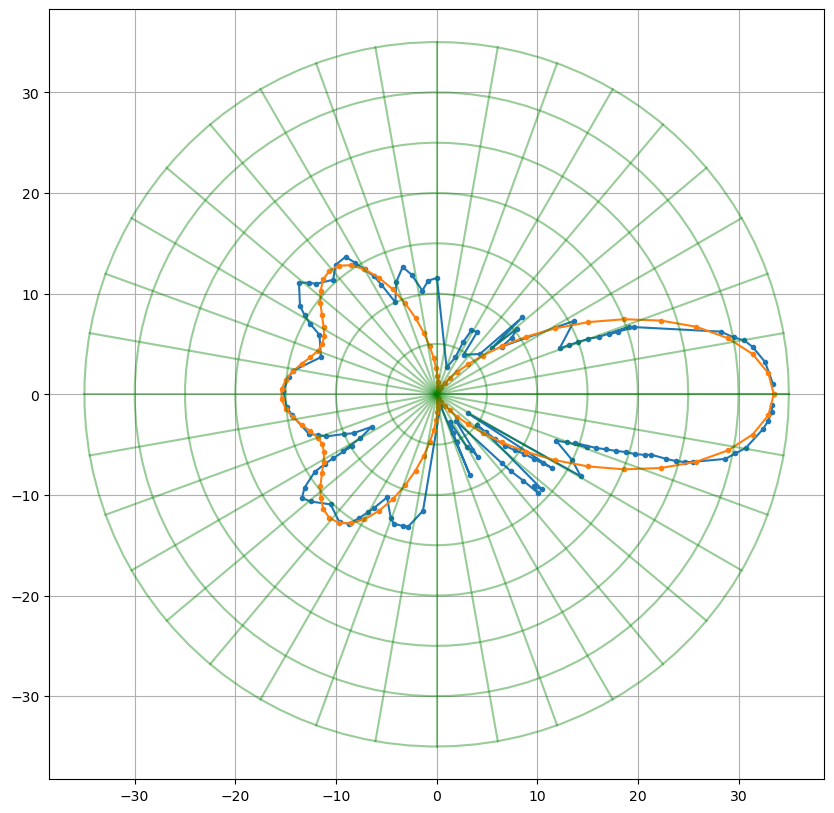

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
def dist(a,b):
    d = a-b
    d[d>np.pi]-=np.pi*2
    d[d<-np.pi]+=np.pi*2
    return d

def getgain(ang):
    apr = 33.5*np.exp(-(dist(ang,0)*1.88)**2)
    apr+= 16*np.exp(-(dist(ang,np.pi*(0.72))*2)**2)
    apr+= 16*np.exp(-(dist(ang,-np.pi*(0.72))*2)**2)
    apr+= 14*np.exp(-(dist(ang,np.pi)*2.3)**2)
    apr-= 20
    return apr

plt.figure(figsize=[10,10])
df = pd.read_csv('yagi.csv',names=['db','angle'])
df = df[df['db']<=15]
df['db']*=13.5/15
df = df.sort_values('angle')
df['angle'] = np.deg2rad(df['angle'])
df['cos'] = np.cos(df['angle']-0.02)
df['sin'] = np.sin(df['angle']-0.02)
df['size'] = df['db']+20
#df['size'] = 10**(df['db']/10)
plt.plot(df['cos']*(df['size']),df['sin']*(df['size']),'.-')
ang = np.linspace(0,np.pi*2,100)
cx = np.cos(ang)
cy = np.sin(ang)
apr = getgain(ang)
size = apr+20
#size = 10**(apr/10)
plt.plot(cx*size,cy*size,'.-')

a = np.linspace(0,2*np.pi,100)
x,y = np.cos(a), np.sin(a)
for r in range(0,36,5):
    plt.plot(x*r,y*r,'-g',alpha=0.4)
for a in np.arange(0,np.deg2rad(360.1),np.deg2rad(10)):
    plt.plot([0,np.cos(a)*35],[0,np.sin(a)*35],'g-',alpha=0.4)
plt.axis('equal')
plt.grid()

#plt.plot(df['cos'],df['sin'],'.')

In [2]:
getgain(np.array([0.0]))

array([13.50000004])

In [3]:
10**(getgain(np.array([0.0]))/10)

array([22.3872116])

In [4]:
class Transmitter:
    def __init__(self,position,ant_type='yagi',power=10, col='k'): #dBm
        self.position = np.array(position)
        self.ant_type = ant_type
        self.power = power
        self.initdirection = np.random.rand()*np.pi*2
        self.direction = self.initdirection
        self.fwhm = np.deg2rad(36)
        self.color = col
    def plot(self):
        plt.plot(self.position[0],self.position[1],'xb')
        arrowsize = 50
        #plt.plot([self.position[0],self.position[0]+np.cos(self.direction)*arrowsize],[self.position[1],self.position[1]+np.sin(self.direction)*arrowsize],'-b')
    def plotsignal(self):
        ang = np.linspace(0,np.pi*2,100)
        a = (ang - self.direction)# % (np.pi*2) - np.pi
        a[a>np.pi]-=np.pi*2
        a[a<-np.pi]+=np.pi*2
        #FWHM is 2.355 sigma, so sigma = 
        #sigma = self.fwhm/2.355
        if self.ant_type=='yagi':
            s = 10**(getgain(a)/10) #np.exp(-a**2/(2*sigma**2))*400
        else:
            s = np.zeros_like(a) #assume omnidirectional
        #s = (-a**2/(2*sigma**2)) #log..
        x = self.position[0]
        y = self.position[1]
        plt.plot(x+np.cos(ang)*s*25,y+np.sin(ang)*s*25,alpha=1,lw=3,color=self.color)
    def plotvector(self,ang):
        #for ang in angs:
        x = self.position[0]
        y = self.position[1]
        plt.plot([x,x+np.cos(ang)*10000],[y,y+np.sin(ang)*10000],'-'+self.color,alpha=0.5,lw=1)
    def getgain(self,angle):
        if self.ant_type=='yagi':
            return getgain(angle - self.direction)
        else:
            return np.zeros_like(angle)
    def settime(self,t):
        self.direction = (self.initdirection + t*0.15)%(np.pi*2) #radians per sec

class Receiver:
    def __init__(self,startposition,velocity):
        self.startposition = np.array(startposition)
        self.velocity = np.array(velocity)
        self.gain = -10
        self.record = {}
    def add_record(self,transmitter_id,signal,time,angle):
        if transmitter_id not in self.record: self.record[transmitter_id] = []
        self.record[transmitter_id].append([time,signal,angle])
        
    def plot(self):
        plt.plot(self.position[0],self.position[1],'og')
    def settime(self,t):
        #self.position = (self.startposition + t*self.velocity)
        a = -2*np.pi*t/400
        self.position = np.array([1500+1300*np.cos(a),1800+1300*np.sin(a)]) #(self.startposition + t*self.velocity)
    def compute_signal(self,transmitter):
        delta = self.position - transmitter.position
        #print(self.position,transmitter.position)
        #print(delta)
        ang = np.arctan2(delta[1],delta[0])
        #print(ang)
        dist = np.linalg.norm(delta)
        #print(transmitter.getgain(np.array([ang])))
        lamb = 0.125 #m (wavelength)
        #transmitter gain + transmitter power + pathloss + reciever gain(assumed to be quite poor: -10)
        return transmitter.getgain(np.array([ang]))+transmitter.power+20*np.log10(lamb/(4*np.pi*dist))+self.gain
        
        
class Model():
    def __init__(self,ant_type,sensorgridx,sensorgridy):
        colors = ['b','g','y','k']
        self.transmitters = []
        i = 0
        for x in sensorgridx:
            for y in sensorgridy:
                self.transmitters.append(Transmitter([x,y],ant_type=ant_type,col=colors[i]))
                i+=1
        self.receivers = []
        self.receivers.append(Receiver([50,50],[5,3]))
        for r in self.receivers:
            r.settime(0)
        for t in self.transmitters:
            t.settime(0)
        

    def plotMap(self,time):
        for t in self.transmitters:
            t.settime(time)
            t.plot()
            t.plotsignal()
        for r in self.receivers:
            r.settime(time)
            r.plot()
            for i,t in enumerate(self.transmitters):
                s = r.compute_signal(t)
                
                
                if s>-94:
                    #if s=-94 --> lw=1, a=0.
                    #if s=-84 --> lw=2, a=0.5,
                    #a = (s[0]+94)/20.0
                    #if a>1: a = 1
                    #if a<0: a = 0
                    a = 1
                    plt.plot([r.position[0],t.position[0]],[r.position[1],t.position[1]],lw=1+(s+94)/10,alpha=a)
                r.add_record(i,s,time,t.direction)
            
    def plotGraph(self,time):
        for i,r in self.receivers[0].record.items():            
            r = np.array(r)
            peaks = (r[10:-10]>r[20:]+15) & (r[10:-10]>r[:-20]+15) & (r[10:-10]>r[11:-9]) & (r[10:-10]>r[9:-11])
            peak_idxs = np.where(peaks)[0]+10
            if len(peak_idxs)>0:
                for r_peak in r[peak_idxs,:]:
                    self.transmitters[i].plotvector(r_peak[2])
            if len(r)<1: continue
            sig = 10**(r[:,1]/10)
            #thresh = 10**(-94/10)
            #plt.plot(r[sig>thresh,0]*20+20,sig[sig>thresh]+20,'-x')
            thresh = -110
            keep = r[:,1]>=thresh
            plt.plot(r[:,0]*10+200,100+(r[:,1]-thresh)*10,'-'+self.transmitters[i].color)
            
            #print(np.max(sig))
        plt.plot([200,2800],[100,100],'k-')
        

    def plotframe(self,i,ax=None):
        """
        Plots a single frame.
        """
        import matplotlib.pyplot as plt

        if ax is None:
            ax = plt.gca()
        plt.title(int(i))
        self.plotMap(i)
        self.plotGraph(i)
        
    def makemovie(self,filename=None):
        """
        Generates a diagnostic/debug movie, saved in 'filename'.
        """
        from moviepy.editor import VideoClip
        from moviepy.video.io.bindings import mplfig_to_npimage
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots(figsize=(10,10))

        def make_frame(t):
            ax.clear()
            ax.set_aspect('equal', 'box')
            ax.set_xlim([0,3000])
            ax.set_ylim([0,3000])
            self.plotframe(t*10,ax=ax)    
            return mplfig_to_npimage(fig)

        Nframes = 25
        animation = VideoClip(make_frame, duration = Nframes)
        if filename is not None:
            animation.write_videofile(filename,fps=25,codec='mpeg4',bitrate='3000k')
        else:
            return animation.ipython_display(fps = 20, loop = False, autoplay = True)
        
    

Moviepy - Building video vid1.mp4.
Moviepy - Writing video vid1.mp4



Moviepy - Done !
Moviepy - video ready vid1.mp4


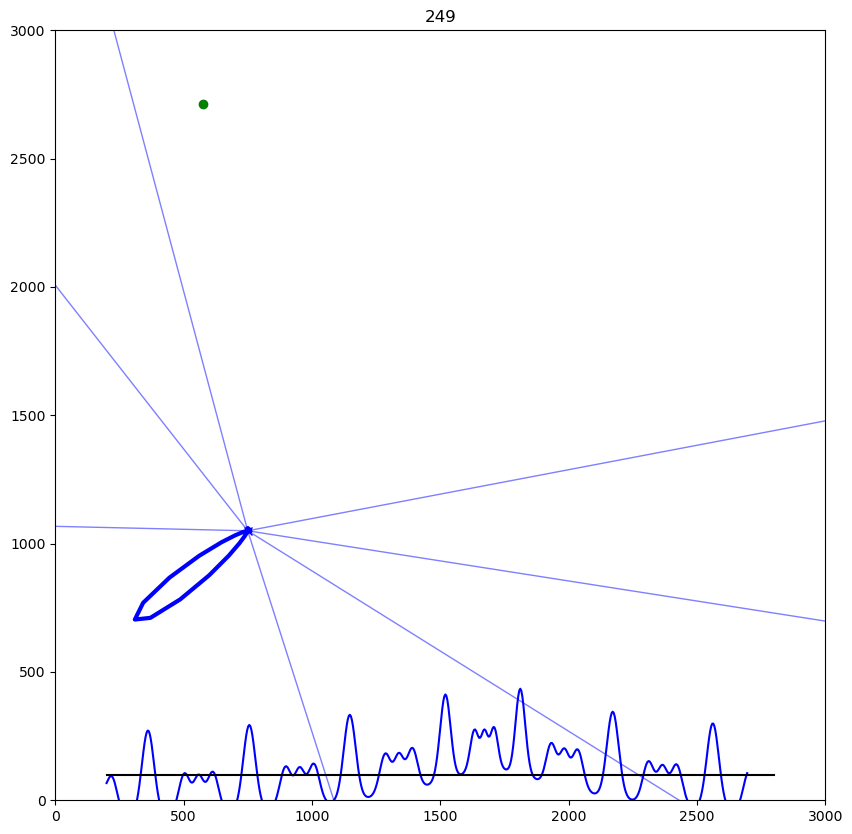

In [5]:
#pip install moviepy
#pip install ffmpeg --upgrade
m = Model('yagi',np.linspace(750,2250,2),np.linspace(1050,2550,2))
#m.transmitters = [m.transmitters[0],m.transmitters[3]]
m.transmitters = [m.transmitters[0]]
m.makemovie('vid1.mp4')

In [6]:
#pip install moviepy
#pip install ffmpeg --upgrade
m = Model('yagi',np.linspace(750,2250,2))
m.transmitters = [m.transmitters[0],m.transmitters[3]]
m.makemovie('vid2.mp4')

TypeError: Model.__init__() missing 1 required positional argument: 'sensorgridy'

In [ ]:
#pip install moviepy
#pip install ffmpeg --upgrade
m = Model('yagi',np.linspace(750,2250,2))
#m.transmitters = [m.transmitters[0],m.transmitters[3]]
#m.transmitters = [m.transmitters[0]]
m.makemovie('vid3.mp4')